In [1]:
import sys
sys.path.append(os.path.abspath(os.path.join(os.pardir)))

In [ ]:
pip install -i https://test.pypi.org/simple/ VASA

In [2]:
import os
import pandas as pd
import geopandas as gpd
from VASA import VASA

/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
# import the data file:
data = pd.read_csv("../test data/lakefire.csv")

# need to ensure that these GEOID's match the ones in our GeoDataFrame
data.origin_census_block_group = "0" + data.origin_census_block_group.astype(str)

data.head()

,origin_census_block_group,date_range_start,distance_traveled_from_home
0,060372713005,2019-07-15 07:00:00,742
1,060372766041,2019-07-15 07:00:00,1799
2,060374334012,2019-07-15 07:00:00,1884
3,060375017003,2019-07-15 07:00:00,2334
4,060375322002,2019-07-15 07:00:00,2791


In [4]:
fire_map = gpd.read_file("../test data/ca_cbgs.geojson") \
    .set_crs(epsg=4326) \
    .to_crs("+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs")

fire_map = fire_map[fire_map["ALAND"] > 0]

fire_map.head()

,ALAND,GEOID,geometry
0,274050,060371044041,"POLYGON ((-1944035.709 -442424.821, -1943863.2..."
1,873636,060371047031,"POLYGON ((-1942149.424 -444386.366, -1941970.9..."
2,136553,060371249032,"POLYGON ((-1944179.245 -454239.078, -1944134.0..."
3,294603,060371047032,"POLYGON ((-1942525.758 -444096.575, -1942336.8..."
4,681800,060371047041,"POLYGON ((-1942660.860 -443120.165, -1942657.7..."


In [ ]:
fire_map.plot()

![CBG Map of Southern California](imgs/lakefire//map.png)

In [5]:
v = VASA(
    df=data,
    gdf=fire_map,
    group_summary=lambda g: g[:5], # county level
    df_group_col="origin_census_block_group",
    gdf_group_col="GEOID",
    date_col="date_range_start",
    temp_res="week",
    date_format="%Y-%m-%d %H:%M:%S"
)

In [6]:
v.filter_group().group()

## Look at missing values:

In [8]:
v.pct_partial_missing()

array([0.06072567])

In [9]:
v.pct_full_missing()

array([19.75102475])

In [7]:
v.fill_missing()

In [11]:
v.pct_full_missing(), v.pct_partial_missing()

(array([0.]), array([0.]))

## Find the weights connection to use:

In [ ]:
v.show_weights_connection(k=7)

![Lakefire KNN spatial weights](imgs/lakefire/knn.png)

In [ ]:
v.show_weights_connection(type="queens")

![Lakefire queens spatial weights](imgs/lakefire/queens.png)

In [ ]:
v.show_weights_connection(k=5, type="union")

![Lakefire Queens and Knn spatial weights](imgs/lakefire/union.png)

## LISA

In [8]:
v.lisa(k=5, type="union")

/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 3540.
  warnings.warn(message)
/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/esda/moran.py:1054: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/esda/moran.py:1054: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/esda/moran.py:1054: RuntimeWarning: invalid value encountered in true_div

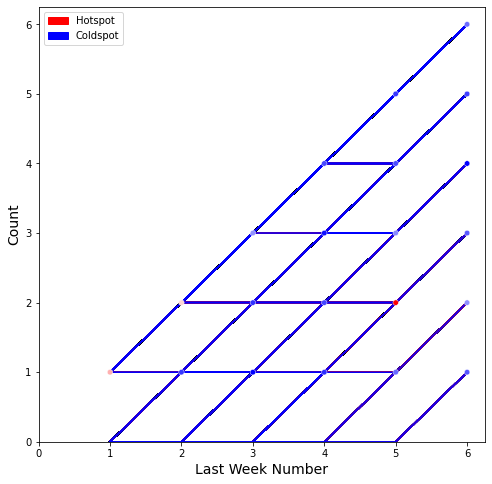

In [17]:
from VASA.scatter import Scatter
sc = Scatter(v)
sc.plot(highlight = "06037")

In [17]:
from VASA.static_choropleth import StackedChoropleth
stcked = StackedChoropleth(v, os.getcwd() + "/imgs/lakefire")

In [ ]:
stcked.plot_count()

![Lakefire count stacked choropleth](imgs/lakefire/count/distance_traveled_from_home.png)

In [ ]:
stcked.plot_recent()

![Lakefire recent stacked choropleth](imgs/lakefire/recent/distance_traveled_from_home.png)